In [22]:
import os

def download_file(file, path, skip_existing=False):
    file_id = file['id']
    request = drive_service.files().get_media(fileId=file_id)
    if skip_existing and os.path.exists(os.path.join(path, file['name'])):
#         print('\t skipping')
        return
    
    with open(os.path.join(path, file['name']), 'wb') as fh:
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()
#             print(f"Download {int(status.progress() * 100)}%. {file_id}")

In [23]:
def download_all_files(path, skip_existing):
    response = drive_service.files().list().execute()
    
    files = response['files']
    page_no = 1
    while response.get('nextPageToken'):
        print('Downloading page', page_no)
        for file in files:
            download_file(file, path, skip_existing=skip_existing)
        
        response = drive_service.files().list(pageToken=response['nextPageToken']).execute()
        files = response['files']
        page_no += 1
    print('Finished Downloading')

In [ ]:
import os

if not os.path.exists('data'): os.makedirs('data')
    
download_all_files('data', skip_existing=True)

In [12]:
import json
import re
import os

def parse_fname_date(fname):
    date_pat = re.compile('(\d{4}-\d{2}-\d{2}T\d{2})')
    return datetime.strptime(date_pat.search(fname).group(0), '%Y-%m-%dT%H')

def parse_cortes(fname):
    """
    convierte el json crudo de cortes en una lista de diccionarios (tambien parsea la descripccion)
    """
    open_func = gzip.open if fname.endswith('gz') else open
    with open_func(fname) as f:
        contents = f.read()
        
    if len(contents) == 0: return []
        
    if isinstance(contents, bytes): contents = contents.decode('utf8')
        
    var_pat = re.compile('addressPoints_Cuadro_D.*?=.*?(?P<lista>.*?);')
    lista = var_pat.search(contents).groupdict()['lista'].strip()[1:-1].strip()

    corte_pat = re.compile('(\[.*?\])')
    cortes = []
    fname_date = parse_fname_date(fname)
    keys = ['latitud', 'longitud', 'misc', 'descr']
    for corte_match in corte_pat.finditer(lista):
        corte = json.loads(corte_match.group(0))
        corte = dict(zip(keys, corte))
        
        lines = corte['descr'].split(',')
        descr_dict = {'tipo': lines[0], 'empresa': lines[1].strip()}
        for line in lines[2:]:
            colon_pos = line.find(':')
            k = line[:colon_pos].strip()
            v = line[colon_pos+1:].strip()
            descr_dict[k.strip().lower()] = v.strip()

        corte.update(descr_dict)
        corte['date_hour'] = fname_date

        cortes.append(corte)
        
    return cortes

In [13]:
def parse_demanda(fname):
    region = int(fname.split('-')[-1].split('.')[0])
    open_func = gzip.open if fname.endswith('gz') else open
    
    with open_func(fname) as f:
        res = json.load(f)
        for doc in res:
            doc['region'] = region
            doc['fecha'] = datetime.strptime(doc['fecha'][:19], '%Y-%m-%dT%H:%M:%S')
    return res

In [14]:
from datetime import timedelta, datetime
import gzip

def parse_clima(fname):
    open_func = gzip.open if fname.endswith('gz') else open

    with open_func(fname) as f:
        clima_content = f.read()
    
    if isinstance(clima_content, bytes): clima_content = clima_content.decode('utf8')
        
    data = clima_content.split(';')[0]
    parsed_data = json.loads(data[6:].replace("'", '"'))
    keys = ['hour', 'ufs_edesur', 'ufs_edenor', 'codigo', 'estado_cielo', 'temperatura']
    parsed_data = [dict(zip(keys, row)) for row in parsed_data]

    fname_date = parse_fname_date(fname)

    hour, minute = map(int, parsed_data[-1]['hour'].split(':'))
    parsed_data[-1]['datetime'] = fname_date.replace(hour=hour, minute=minute)

    for i in range(len(parsed_data)-2, -1, -1):
        current_row = parsed_data[i]
        current_time = datetime.strptime(current_row['hour'], '%H:%M')

        prev_row = parsed_data[i+1]
        prev_time = datetime.strptime(prev_row['hour'], '%H:%M')

        delta = (prev_time - current_time)
        if delta.total_seconds() < 0:
            delta += timedelta(days=1)

        current_row['datetime'] = prev_row['datetime'] - delta
    
    return parsed_data

In [15]:
cortes = []
demanda = []
clima = []
for fname in os.listdir('data'):
    if fname.startswith('cortes'):
        parsing_func = parse_cortes
        output_list = cortes
    elif fname.startswith('clima'):
        parsing_func = parse_clima
        output_list = clima
    else:
        parsing_func = parse_demanda
        output_list = demanda
        
    fname = 'data/' + fname
    output_list.extend(parsing_func(fname))
    

In [11]:
debug

> /var/folders/55/555sz06s5477c_l2bss1ndnwmmmmq7/T/ipykernel_16979/1385208182.py(20)parse_cortes()
     18 
     19     var_pat = re.compile('addressPoints_Cuadro_D.*?=.*?(?P<lista>.*?);')
---> 20     lista = var_pat.search(contents).groupdict()['lista'].strip()[1:-1].strip()
     21 
     22     corte_pat = re.compile('(\[.*?\])')

ipdb> contents
''
ipdb> list
     15         contents = f.read()
     16 
     17     if isinstance(contents, bytes): contents = contents.decode('utf8')
     18 
     19     var_pat = re.compile('addressPoints_Cuadro_D.*?=.*?(?P<lista>.*?);')
---> 20     lista = var_pat.search(contents).groupdict()['lista'].strip()[1:-1].strip()
     21 
     22     corte_pat = re.compile('(\[.*?\])')
     23     cortes = []
     24     fname_date = parse_fname_date(fname)
     25     keys = ['latitud', 'longitud', 'misc', 'descr']

ipdb> list 10
      5 def parse_fname_date(fname):
      6     date_pat = re.compile('(\d{4}-\d{2}-\d{2}T\d{2})')
      7     return datetime.s

In [16]:
import pandas as pd

demanda_df = pd.DataFrame(demanda)
demanda_df.drop_duplicates(subset=['fecha', 'region'], inplace=True)

In [17]:
len(demanda_df)

7490

In [18]:
region2str = {
    1077: 'EDESUR',  1078: 'EDENOR', 
}

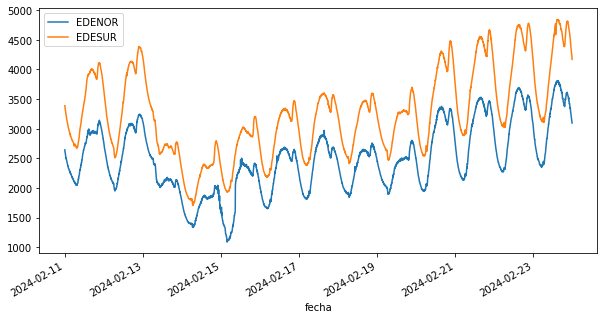

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
for region in demanda_df.region.unique():
    demanda_df[demanda_df.region==region].set_index('fecha').demAyer.plot(label=region2str[region])
    
plt.legend(loc='best')

In [20]:
cortes_df = pd.DataFrame(cortes)
cortes_df['usuarios afectados'] = cortes_df['usuarios afectados'].apply(int)
cortes_df['region'] = cortes_df.empresa.apply(lambda e: 1077 if e == 'EDESUR S.A.' else 1078)


In [23]:
doc.keys()

AttributeError: 'tuple' object has no attribute 'keys'

In [24]:
clima_df = pd.DataFrame(clima)
clima_df['date_hour'] = clima_df.datetime.apply(lambda x: x.replace(minute=0))
clima_df['temperatura'] = clima_df['temperatura'].astype('int')

In [25]:
clima_df.head()

,hour,ufs_edesur,ufs_edenor,codigo,estado_cielo,temperatura,datetime,date_hour
0,01:20,41164,1969,01n,Cielo Claro,26,2024-02-11 01:20:00,2024-02-11 01:00:00
1,01:25,41164,1969,01n,Cielo Claro,26,2024-02-11 01:25:00,2024-02-11 01:00:00
2,01:30,38574,1969,01n,Cielo Claro,26,2024-02-11 01:30:00,2024-02-11 01:00:00
3,01:35,38574,1969,01n,Cielo Claro,25,2024-02-11 01:35:00,2024-02-11 01:00:00
4,01:40,38574,1969,01n,Cielo Claro,25,2024-02-11 01:40:00,2024-02-11 01:00:00


In [26]:
clima_df_hour = (
    clima_df.groupby('date_hour')
            .agg({'estado_cielo': pd.Series.mode, 'ufs_edesur': 'mean', 
                  'ufs_edenor': 'mean', 'temperatura': 'mean'})
           .reset_index()
)

In [27]:
demanda_df['date_hour'] = demanda_df.fecha.apply(lambda x: x.replace(minute=0))
demanda_df_hour = (
    demanda_df.groupby(['date_hour', 'region'])
            .agg({'demHoy': 'mean', 'demAyer': 'mean', 'demSemanaAnt': 'mean'})
            .reset_index()
)

In [28]:
merged = (
    cortes_df.merge(clima_df_hour, left_on='date_hour', right_on='date_hour')
             .merge(demanda_df_hour, left_on=('date_hour', 'region'), right_on=('date_hour', 'region'))
)

In [29]:
len(cortes_df), len(clima_df), len(merged)

(104214, 14976, 100154)

In [30]:
pd.options.display.max_columns = 1000

In [31]:
merged.head()

,latitud,longitud,misc,descr,tipo,empresa,partido,localidad,subestacion,alimentador,usuarios afectados,hora estimada de normalizacion,date_hour,region,estado_cielo,ufs_edesur,ufs_edenor,temperatura,demHoy,demAyer,demSemanaAnt
0,-34.658704,-58.354090,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,AVELLANEDA,DOCK SUD,9 DE JULIO,R:279-2-23/279-2-23,341,2024-02-15 02:56,2024-02-14 23:00:00,1077,Cielo Claro,1335.5,92.0,21.916667,NaN,2433.166667,4881.833333
1,-34.640539,-58.520141,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,LINIERS,LURO,R:038-3-35/038-3-35,578,2024-02-15 02:28,2024-02-14 23:00:00,1077,Cielo Claro,1335.5,92.0,21.916667,NaN,2433.166667,4881.833333
2,-34.639500,-58.413200,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,CAPITAL,NUEVA POMPEYA,NaN,NaN,1,NaN,2024-02-14 23:00:00,1077,Cielo Claro,1335.5,92.0,21.916667,NaN,2433.166667,4881.833333
3,-34.611300,-58.388800,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,CAPITAL,MONSERRAT,NaN,NaN,16,NaN,2024-02-14 23:00:00,1077,Cielo Claro,1335.5,92.0,21.916667,NaN,2433.166667,4881.833333
4,-34.614700,-58.391900,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,CAPITAL,MONSERRAT,NaN,NaN,56,NaN,2024-02-14 23:00:00,1077,Cielo Claro,1335.5,92.0,21.916667,NaN,2433.166667,4881.833333


# Preguntas

1) Sube la demanda cuando aumenta la temperatura?

2) Cuales son las zonas con mas demanda (con la data que tenemos no la podemos contestar)

3) Cuales son las zonas con mas cortes. Coinciden con las de mayor demanda?

4) El estado del cielo correlaciona con la demanda y con los cortes?

5) Hay algun horario de mayor cantidad de cortes?

6) Cuales son las zonas con mas usuarios afectados? 


### 1) Sube la demanda cuando aumenta la temperatura?


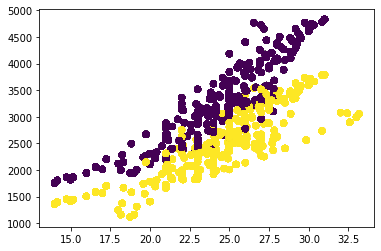

In [32]:
plt.scatter(merged.temperatura, merged.demHoy, c=merged.region)

### 3) Cuales son las zonas con mas cortes. Coinciden con las de mayor demanda?


In [33]:
cortes_df['partido_localidad'] = cortes_df.partido + "/" + cortes_df.localidad

In [34]:
cortes_df.partido_localidad.value_counts().head(5)

TIGRE/DELTA 1RA SECCION (TI)           7526
FLORENCIO VARELA/FLORENCIO VARELA      5826
SAN FERNANDO/DELTA 2DA SECCION (SF)    4454
CAPITAL RP/CABALLITO RP                3779
SAN FERNANDO/DELTA 3RA SECCION (SF)    3652
Name: partido_localidad, dtype: int64

### 4) El estado del cielo correlaciona con la demanda y con los cortes?


In [35]:
import numpy as np

[e for e in dir(np) if 'std' in e]

['nanstd', 'std']

In [36]:
clima_df.estado_cielo.value_counts()

Cielo Claro                     6929
Algo De Nubes                   2471
Nubes Dispersas                 2065
Muy Nuboso                      1926
Nubes                            817
Lluvia Moderada                  289
Lluvia Ligera                    256
Tormenta Con Lluvia               90
Tormenta Con Lluvia Ligera        82
Lluvia De Gran Intensidad         35
Tormenta Con Lluvia Intensa       16
Name: estado_cielo, dtype: int64

# No se por que no anda, corto aca

In [57]:
merged.estado_cielo.value_counts()
(
    merged.groupby('estado_cielo')
          .agg({'region': 'count', 'demHoy': 'mean'})
          .rename(columns=dict(region='cortes'))
          .sort_values('cortes', ascending=False)
)

TypeError: unhashable type: 'numpy.ndarray'

In [109]:
plt.scatter(merged)

<module 'matplotlib.pyplot' from '/Users/przivic/miniconda3/envs/mlp2022/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [ ]:
demanda_df, cortes_df, clima_df

In [105]:
cortes_df.groupby('alimentador').latitud.nunique()

alimentador
N:                                           76
N:089-1-14/089-1-14                           1
N:SAN JUSTO/164-TR1/164-5518                  1
R:                                           97
R:020-4-45/020-4-45                           1
R:022-1-15/022-1-15                           1
R:023-1-14/023-1-14                           4
R:073-4-46/073-4-46                           1
R:077-3-34/077-3-34                          12
R:079-5-54/079-5-54                           5
R:089-1-16/089-1-16                           1
R:113-1-17/113-1-17                           8
R:122-4-41/122-4-41                           5
R:122-4-43/122-4-43                          12
R:122-4-45/122-4-45                           2
R:122-4-47/122-4-47                           8
R:143-3-36/143-3-36                           3
R:147-2-22/147-2-22                           1
R:172-2-26/172-2-26                           6
R:179-2-22/179-2-22                           1
R:182-1-16/182-1-16         

In [87]:
cortes_df.sample(10)

,latitud,longitud,misc,descr,tipo,empresa,partido,localidad,subestacion,alimentador,usuarios afectados,hora estimada de normalizacion,date_hour,region
8714,-34.624256,-59.044691,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,GRAL RODRIGUEZ,GRAL RODRIGUEZ,S/D,R:MALVINAS/169-TR2/169-5476/255-5521,5,2024-02-12 01:00,2024-02-11 22:00:00,1078
2473,-34.767300,-58.221500,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,BERAZATEGUI,BERAZATEGUI,NaN,NaN,69,NaN,2024-02-11 07:00:00,1077
7210,-34.289506,-58.586989,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,TIGRE,DELTA 1RA SECCION (TI),S/D,R:TIGRE/153-TR2/153-5526,12,Sin datos,2024-02-11 09:00:00,1078
9136,-34.628725,-58.436919,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,PARQUE CHACABUCO,S/D,R:,21,Sin datos,2024-02-12 01:00:00,1077
5626,-34.626183,-58.445645,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,CABALLITO RP,ALBERDI,N:218-3-32/218-3-32,22,2024-02-12 13:58,2024-02-12 12:00:00,1077
1092,-34.614974,-58.432988,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,478,2024-02-11 14:54,2024-02-11 02:00:00,1077
5944,-34.611786,-58.444079,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,606,Sin datos,2024-02-11 23:00:00,1077
2645,-35.064371,-58.545159,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,SAN VICENTE,SAN VICENTE,GLEW,R:277-4-44/277-4-44/271-4-81,1,2024-02-11 14:41,2024-02-11 13:00:00,1077
9642,-34.852165,-58.259581,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,FLORENCIO VARELA,FLORENCIO VARELA,BOSQUES,R:185-2-25/185-2-25,5,2024-02-11 21:11,2024-02-11 14:00:00,1077
7036,-34.711000,-58.429800,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,LANUS,LANUS,NaN,NaN,21,NaN,2024-02-12 07:00:00,1077


In [38]:
cortes_df.groupby('alimentador').latitud.count().sort_values(ascending=False)

alimentador
R:TIGRE/153-TR2/153-5526           5276
R:15-2521                          4727
R:                                 2531
N:                                 2084
R:185-1-16/185-1-16                2067
                                   ... 
R:TORTUGUITAS/252-TR2/252-5534        1
R:FORD/151-TR2/151-5531               1
R:ALTOS/272-TR2/272-5533              1
R:ARA SAN JUAN/362-TR2/362-5525       1
R:SAN JUSTO/164-TR1/164-5512          1
Name: latitud, Length: 454, dtype: int64

In [87]:
cortes_df.sample(10)

,latitud,longitud,misc,descr,tipo,empresa,partido,localidad,subestacion,alimentador,usuarios afectados,hora estimada de normalizacion,date_hour,region
8714,-34.624256,-59.044691,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,GRAL RODRIGUEZ,GRAL RODRIGUEZ,S/D,R:MALVINAS/169-TR2/169-5476/255-5521,5,2024-02-12 01:00,2024-02-11 22:00:00,1078
2473,-34.767300,-58.221500,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,BERAZATEGUI,BERAZATEGUI,NaN,NaN,69,NaN,2024-02-11 07:00:00,1077
7210,-34.289506,-58.586989,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,TIGRE,DELTA 1RA SECCION (TI),S/D,R:TIGRE/153-TR2/153-5526,12,Sin datos,2024-02-11 09:00:00,1078
9136,-34.628725,-58.436919,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,PARQUE CHACABUCO,S/D,R:,21,Sin datos,2024-02-12 01:00:00,1077
5626,-34.626183,-58.445645,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,CABALLITO RP,ALBERDI,N:218-3-32/218-3-32,22,2024-02-12 13:58,2024-02-12 12:00:00,1077
1092,-34.614974,-58.432988,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,478,2024-02-11 14:54,2024-02-11 02:00:00,1077
5944,-34.611786,-58.444079,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,606,Sin datos,2024-02-11 23:00:00,1077
2645,-35.064371,-58.545159,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,SAN VICENTE,SAN VICENTE,GLEW,R:277-4-44/277-4-44/271-4-81,1,2024-02-11 14:41,2024-02-11 13:00:00,1077
9642,-34.852165,-58.259581,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,FLORENCIO VARELA,FLORENCIO VARELA,BOSQUES,R:185-2-25/185-2-25,5,2024-02-11 21:11,2024-02-11 14:00:00,1077
7036,-34.711000,-58.429800,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,LANUS,LANUS,NaN,NaN,21,NaN,2024-02-12 07:00:00,1077


In [21]:
import folium
from folium.plugins import HeatMap

# Create a base map using OpenStreetMap

m = folium.Map(location=[cortes_df.latitud.median(), cortes_df.longitud.median()], zoom_start=12)

# Sample data points (replace with your own data)
# data_points = [(latitude1, longitude1), (latitude2, longitude2), ...]
data_points = []
for doc in cortes_df.groupby(['latitud', 'longitud']):
    data_points.append((doc['latitud'], doc['longitud'], int(doc['usuarios afectados'])))

# Add a heatmap layer
HeatMap(data_points, radius=20).add_to(m)

# OR
m

TypeError: tuple indices must be integers or slices, not str